# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Custom Dataset class](#1b)
    - [Define Train-Test-Split](#1c)
    - [Print positive and negative Sample](#1d)
2. [Define Model](#2)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download UTKFace and signature-verification Dataset<a class="anchor" id="1a">

In [6]:
import opendatasets as od 
import pandas 

!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
!unzip UTKFace.zip -d data && rm UTKFace.zip
!rm -rf __MACOSX/
!rm -rf data/__MACOSX

  
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 

!mv signature-matching/custom data
!rmdir signature-matching/
!mv data/custom data/signature

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Custom Dataset classes<a class="anchor" id="1b">

##### Face Dataset<a class="anchor" id="1b">

In [2]:
class FaceNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
# Load the training dataset
face_train_folder_dataset = datasets.ImageFolder(root="./data/faces/training/")
face_test_folder_dataset = datasets.ImageFolder(root="./data/faces/testing/")


# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])


# Initialize the network
face_train_dataset = FaceNetworkDataset(imageFolderDataset=face_train_folder_dataset, transform=transformation)

train_size = int(0.8 * len(face_train_dataset))
valid_size = len(face_train_dataset) - train_size
face_train_dataset, face_valid_dataset = torch.utils.data.random_split(face_train_dataset, [train_size, valid_size])

face_test_dataset = FaceNetworkDataset(imageFolderDataset=face_test_folder_dataset, transform=transformation)

# Verify the length of datasets
print(f"Number of training samples: {len(face_train_dataset)}")
print(f"Number of validation samples: {len(face_valid_dataset)}")
print(f"Number of testing samples: {len(face_test_dataset)}")


Number of training samples: 296
Number of validation samples: 74
Number of testing samples: 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.81960785].


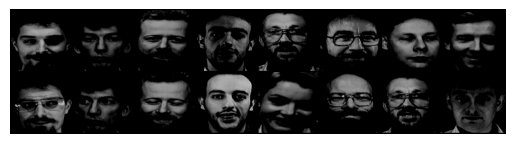

[0. 0. 0. 0. 1. 1. 1. 1.]


In [4]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(face_valid_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

##### Signature Dataset<a class="anchor" id="1b">

In [5]:
import pandas as pd
import os
import PIL
class SignatureNetworkDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):        
        self.transform = transform
        self.root_dir = root_dir
        self.data = df

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img0_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        img1_name = os.path.join(self.root_dir, self.data.iloc[idx, 1])
        image0 = Image.open(img0_name)
        image1 = Image.open(img1_name)
        
        image0 = image0.convert("L")
        image1 = image1.convert("L")

        if self.transform:
            image0 = self.transform(image0)
            image1 = self.transform(image1)

        return image0, image1, torch.from_numpy(np.array([int(self.data.iloc[idx, 2])], dtype=np.float32))
        
    def __len__(self):
        return len(self.data)

In [6]:
from sklearn.model_selection import train_test_split
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

signature_train_csv = "./data/signature/train_data.csv"
signature_test_csv = "./data/signature/test_data.csv"
signature_image_dir = "./data/signature/full"

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

signature_train_df = pd.read_csv(signature_train_csv)
signature_test_df = pd.read_csv(signature_test_csv)
train_df, valid_df = train_test_split(signature_train_df, test_size=0.2,random_state = 42)

# Initialize the network
siamese_dataset = FaceNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation)

signature_train_dataset = SignatureNetworkDataset(df=train_df, root_dir=signature_image_dir, transform=transformation)
signature_valid_dataset = SignatureNetworkDataset(df=valid_df, root_dir=signature_image_dir, transform=transformation)
signature_test_dataset = SignatureNetworkDataset(df=signature_test_df, root_dir=signature_image_dir, transform=transformation)

print(f"Number of training samples: {len(signature_train_dataset)}")
print(f"Number of validation samples: {len(signature_valid_dataset)}")
print(f"Number of testing samples: {len(signature_test_dataset)}")

Number of training samples: 61376
Number of validation samples: 15345
Number of testing samples: 8525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5921569..1.0].


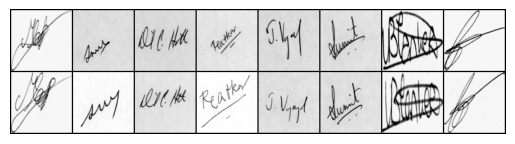

[1. 0. 1. 0. 1. 1. 1. 1.]


In [7]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(signature_train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

#### Define Train-Test-Split<a class="anchor" id="1c">

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

In [8]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [9]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [10]:
import torch
from torch.utils.data import DataLoader

def evaluate(validation_loader, net, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img0, img1, label in validation_loader:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            val_loss += loss_contrastive.item()
    return val_loss / len(validation_loader)

def train(train_loader, val_loader, net, optimizer, criterion):
    counter = []
    loss_history = [] 
    val_loss_history = []
    iteration_number = 0

    # Iterate through the epochs
    for epoch in range(100):

        net.train()
        # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_loader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches, print out the loss and evaluate on validation set
            if i % 10 == 0:
                print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

                val_loss = evaluate(val_loader, net, criterion)
                val_loss_history.append(val_loss)
                print(f"Validation loss after {iteration_number} iterations: {val_loss}\n")

    show_plot(counter, loss_history, val_loss_history)


# Function to evaluate the model on the test dataset
def evaluate_test(test_loader, net, criterion):
    net.eval()
    test_loss = 0.0
    with torch.no_grad():
        for img0, img1, label in test_loader:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            test_loss += loss_contrastive.item()
    test_loss = test_loss / len(test_loader)
    print(f"Test loss: {test_loss}")
    return test_loss

# Function to plot the loss history
def show_plot(counter, loss_history, val_loss_history):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(counter, loss_history, label='Training Loss')
    plt.plot(counter, val_loss_history, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Epoch number 0
 Current loss 12.870068550109863

Validation loss after 10 iterations: 11.232265710830688

Epoch number 1
 Current loss 7.458428382873535

Validation loss after 20 iterations: 3.983422338962555

Epoch number 2
 Current loss 4.244661808013916

Validation loss after 30 iterations: 3.6052287817001343

Epoch number 3
 Current loss 3.2996227741241455

Validation loss after 40 iterations: 4.657382488250732

Epoch number 4
 Current loss 3.285217046737671

Validation loss after 50 iterations: 2.694672644138336

Epoch number 5
 Current loss 3.005186080932617

Validation loss after 60 iterations: 2.5000522136688232

Epoch number 6
 Current loss 2.3793585300445557

Validation loss after 70 iterations: 2.967075765132904

Epoch number 7
 Current loss 1.9917283058166504

Validation loss after 80 iterations: 3.646341323852539

Epoch number 8
 Current loss 2.9276514053344727

Validation loss after 90 iterations: 5.165719270706177

Epoch number 9
 Current loss 2.967529773712158

Validati

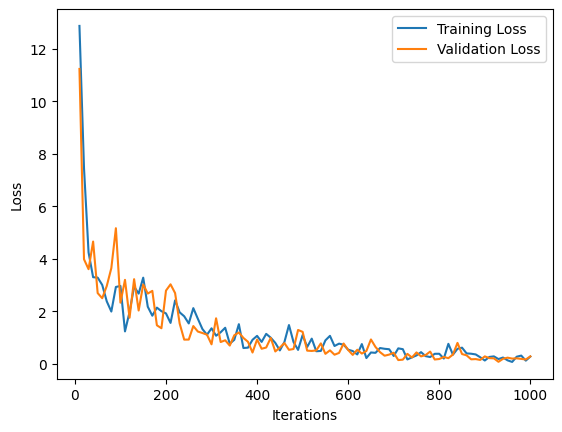

RuntimeError: mat1 and mat2 shapes cannot be multiplied (384x1 and 384x1024)

In [80]:
# Load the training dataset
face_train_loader = DataLoader(face_train_dataset, shuffle=True, num_workers=8, batch_size=64)
face_valid_loader = DataLoader(face_valid_dataset, shuffle=True, num_workers=8, batch_size=64)

face_net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.0005 )
train(face_train_loader, face_valid_loader, face_net, optimizer, criterion)
test_loss = evaluate_test(face_test_dataset, face_net, criterion)

Epoch number 0
 Current loss 11.708673477172852

Epoch number 1
 Current loss 6.66883659362793

Epoch number 2
 Current loss 4.398118019104004

Epoch number 3
 Current loss 3.4327454566955566

Epoch number 4
 Current loss 3.281646728515625

Epoch number 5
 Current loss 2.0661404132843018

Epoch number 6
 Current loss 2.5525670051574707

Epoch number 7
 Current loss 2.97332501411438

Epoch number 8
 Current loss 3.824305295944214

Epoch number 9
 Current loss 2.6636462211608887

Epoch number 10
 Current loss 2.1159608364105225

Epoch number 11
 Current loss 1.606869101524353

Epoch number 12
 Current loss 1.688983678817749

Epoch number 13
 Current loss 1.6785944700241089

Epoch number 14
 Current loss 1.715652346611023

Epoch number 15
 Current loss 2.9872679710388184

Epoch number 16
 Current loss 1.4616870880126953

Epoch number 17
 Current loss 1.9033442735671997

Epoch number 18
 Current loss 1.5039591789245605

Epoch number 19
 Current loss 1.644806981086731

Epoch number 20
 Curr

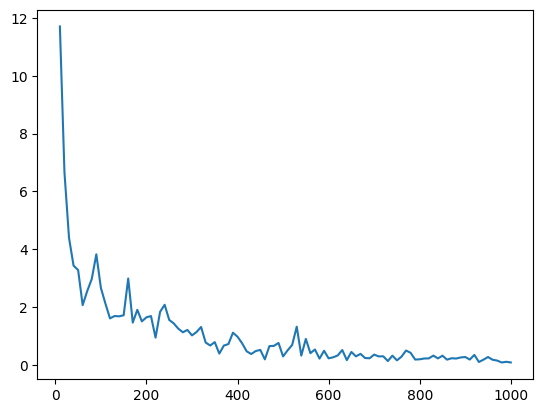

In [29]:
# Load the training dataset
face_loader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

face_net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.0005 )
train(face_loader, face_net, optimizer, criterion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..0.81960785].


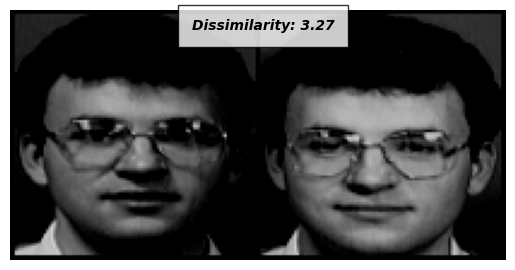

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.81960785].


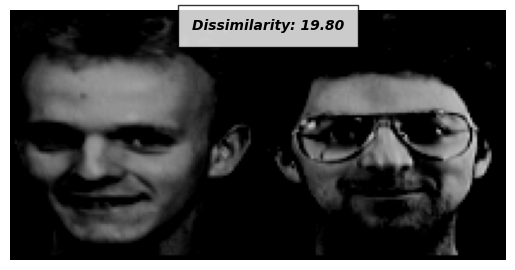

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.81960785].


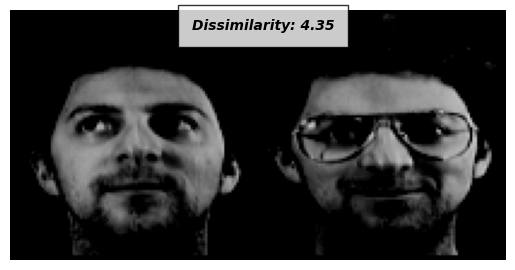

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.81960785].


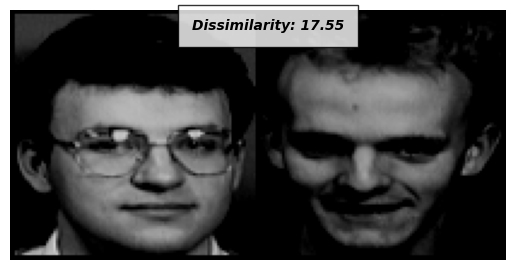

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].


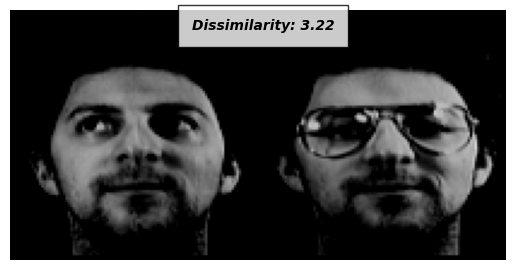

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..0.78039217].


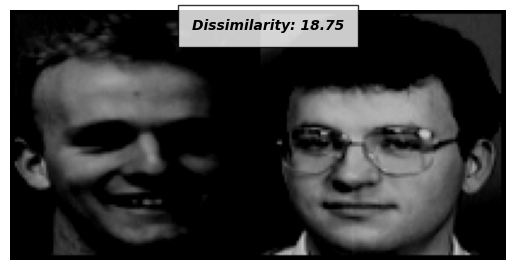

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..0.79607844].


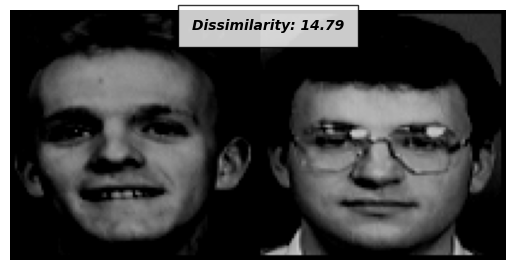

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.81960785].


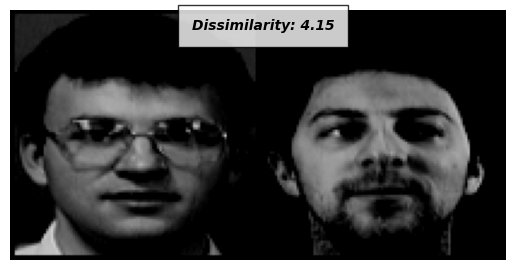

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.8117647].


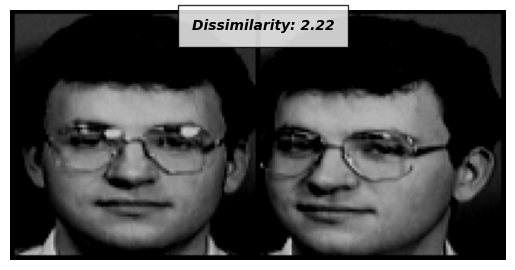

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.8117647].


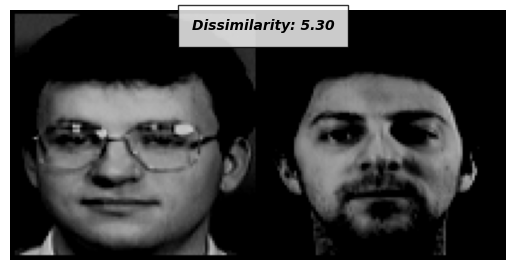

In [33]:
# Locate the test dataset and load it into the FaceNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = FaceNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)


for i in range(10):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = face_net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')